In [1]:
import os
import json
import shutil
import random
from tqdm import tqdm
from pathlib import Path

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

import numpy as np
import pandas as pd

from ultralytics import YOLO

In [3]:
class config:

    TRAIN_DIR = 'train/'
    VALID_DIR = 'val/'
    TEST_DIR = 'test/'

In [4]:
print(f'There are total {len(os.listdir(config.TRAIN_DIR))} train images')
print(f'There are total {len(os.listdir(config.VALID_DIR))} valid images')
print(f'There are total {len(os.listdir(config.TEST_DIR))} test images')

There are total 1548 train images
There are total 487 valid images
There are total 217 test images


In [5]:
from collections import Counter
def check_file_type(image_folder):
    extension_type = []
    file_list = os.listdir(image_folder)
    for file in file_list:
      extension_type.append(file.rsplit(".", 1)[1].lower())
    print(Counter(extension_type).keys())
    print(Counter(extension_type).values())
    
    
check_file_type(config.TRAIN_DIR)

dict_keys(['jpg', 'json'])
dict_values([1547, 1])


In [6]:
import tqdm
def check_image_size(image_folder):
    total_img_list = glob.glob(os.path.join(image_folder,"*"))
    counter = 0
    for image in total_img_list:
        try:
            img = cv2.imread(image)
            print(img.shape)
        except:
            print("This {} is problematic.".format(image))
    return counter 

In [7]:
class_labels = {
    'coca-cola' : 0,
    'fanta' : 1,
    'sprite' : 2
}

In [ ]:
modes =['train', 'val', 'test']
make_df(modes)

In [9]:
train = pd.read_csv('train_data.csv')
valid = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [10]:
def count_bottles(df):
    data = []
    file_names = df['file_name'].unique()
    for f in file_names:
        new = df[df['file_name'] == f]
        coca_cola = 0
        fanta = 0
        sprite = 0
        for category in new['category_name']:
            if category == 'coca-cola':
                coca_cola += 1
            elif category == 'fanta':
                fanta += 1
            elif category == 'sprite':
                sprite += 1
        data.append({'file_name': f, 'coca-cola': coca_cola, 'fanta': fanta, 'sprite': sprite})
    count_df = pd.DataFrame(data)
    new_df = df.merge(count_df, on='file_name', how='left')
    return new_df

In [11]:
def preprocess_bbox(df):
    bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
    for i, column in enumerate(['x', 'y', 'w', 'h']):
        df[column] = bboxs[:,i]
    df.drop(columns=['bbox'], inplace=True)
    new_df = count_bottles(df)
    return new_df

In [12]:
train_df = preprocess_bbox(train)
val_df = preprocess_bbox(valid)
test_df = preprocess_bbox(test)

In [14]:
train

,image_id,file_name,height,width,category_id,area,category_name,x,y,w,h
0,0,01_20220315_151531_bmp_jpg.rf.3758e0df4f70a0be...,1080,1920,0,35112.0000,coca-cola,625.0,926.0,228.00,154.00
1,0,01_20220315_151531_bmp_jpg.rf.3758e0df4f70a0be...,1080,1920,2,49370.7200,sprite,883.0,0.0,207.44,238.00
2,0,01_20220315_151531_bmp_jpg.rf.3758e0df4f70a0be...,1080,1920,1,39991.7750,fanta,648.0,28.0,202.49,197.50
3,0,01_20220315_151531_bmp_jpg.rf.3758e0df4f70a0be...,1080,1920,0,48834.5136,coca-cola,1257.0,47.0,231.52,210.93
4,0,01_20220315_151531_bmp_jpg.rf.3758e0df4f70a0be...,1080,1920,1,37378.0722,fanta,338.0,88.0,225.02,166.11
...,...,...,...,...,...,...,...,...,...,...,...
42751,1546,01_20220316_115723_bmp_jpg.rf.ffbeaeec6efd142e...,1080,1920,0,59287.5000,coca-cola,448.0,783.0,237.15,250.00
42752,1546,01_20220316_115723_bmp_jpg.rf.ffbeaeec6efd142e...,1080,1920,1,80255.9500,fanta,653.0,745.0,239.57,335.00
42753,1546,01_20220316_115723_bmp_jpg.rf.ffbeaeec6efd142e...,1080,1920,2,46634.8000,sprite,641.0,0.0,252.08,185.00
42754,1546,01_20220316_115723_bmp_jpg.rf.ffbeaeec6efd142e...,1080,1920,1,68993.2250,fanta,1111.0,778.0,231.91,297.50


In [21]:
train['category_id'].value_counts()

2    14665
0    14556
1    13535
Name: category_id, dtype: int64

In [15]:
num_ex = train[train["category_id"].notnull()].groupby("image_id").apply(lambda x: len(x))
print("max num bottles:", max(num_ex.values))
print("min num bottles:", min(num_ex.values))

max num bottles: 41
min num bottles: 4


<Axes: xlabel='num_bottles', ylabel='Count'>

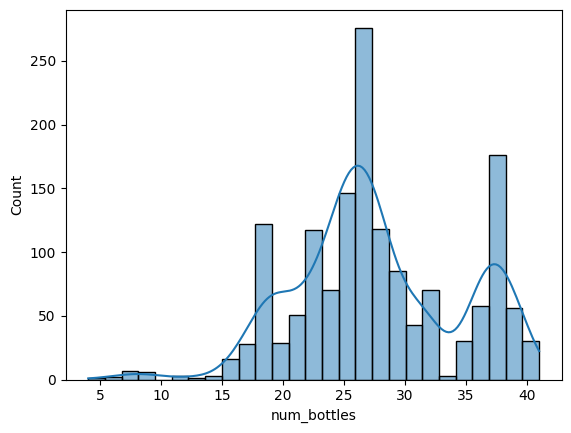

In [16]:
sns.histplot(data={
    "num_bottles": num_ex.values
    }, x="num_bottles", kde=True)

In [21]:
num_cl_ex = train[train["category_name"].notnull()].groupby(["image_id", "category_name"]).apply(lambda x: len(x))
num_cl_ex_per_images = [[item[0][1], item[1]] for item in list(zip(num_cl_ex.index.to_list(), num_cl_ex.values))]

print("max coca-cola bottles:", max([item[1] for item in filter(lambda x: x[0] == "coca-cola", num_cl_ex_per_images)]))
print("min coca-cola bottles:", min([item[1] for item in filter(lambda x: x[0] == "coca-cola", num_cl_ex_per_images)]))
print("max fanta bottles:", max([item[1] for item in filter(lambda x: x[0] == "fanta", num_cl_ex_per_images)]))
print("min fanta bottles:", min([item[1] for item in filter(lambda x: x[0] == "fanta", num_cl_ex_per_images)]))
print("max sprite bottles:", max([item[1] for item in filter(lambda x: x[0] == "sprite", num_cl_ex_per_images)]))
print("min sprite bottles:", min([item[1] for item in filter(lambda x: x[0] == "sprite", num_cl_ex_per_images)]))

max coca-cola bottles: 39
min coca-cola bottles: 1
max fanta bottles: 38
min fanta bottles: 1
max sprite bottles: 41
min sprite bottles: 1


<Axes: xlabel='num_bottles', ylabel='Count'>

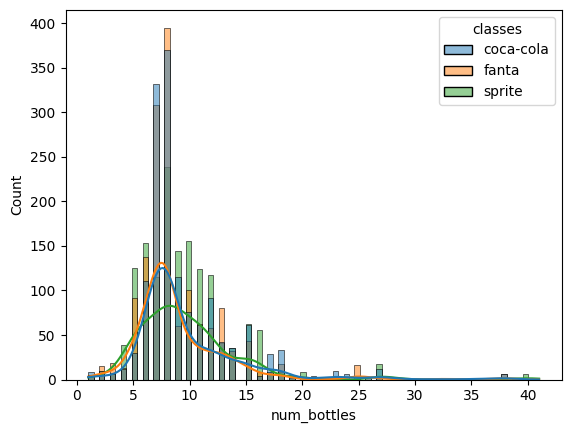

In [20]:
sns.histplot(data={
    "num_bottles": [item[1] for item in num_cl_ex_per_images],
    "classes":  [item[0] for item in num_cl_ex_per_images]
    }, x="num_bottles", hue="classes", kde=True)

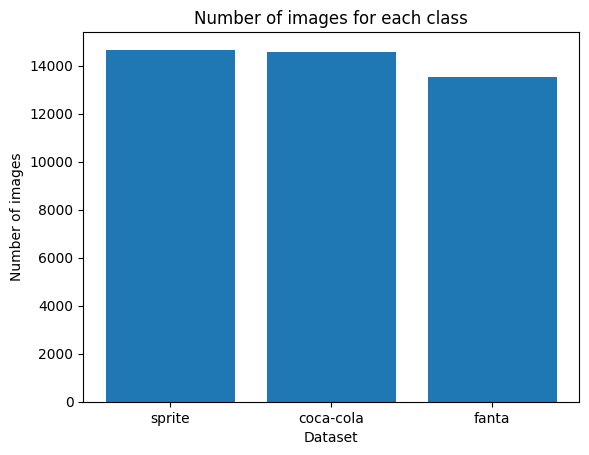

Number of images in each WSI: 
sprite       14665
coca-cola    14556
fanta        13535
Name: category_name, dtype: int64


In [18]:
#bar plot for class distribution
plt.bar(list(map(str, train_df['category_name'].value_counts().index)), train_df['category_name'].value_counts().values)

plt.xlabel('Dataset')
plt.ylabel('Number of images')
plt.title('Number of images for each class')

plt.show()

print(f"Number of images in each WSI: \n{train_df['category_name'].value_counts()}")

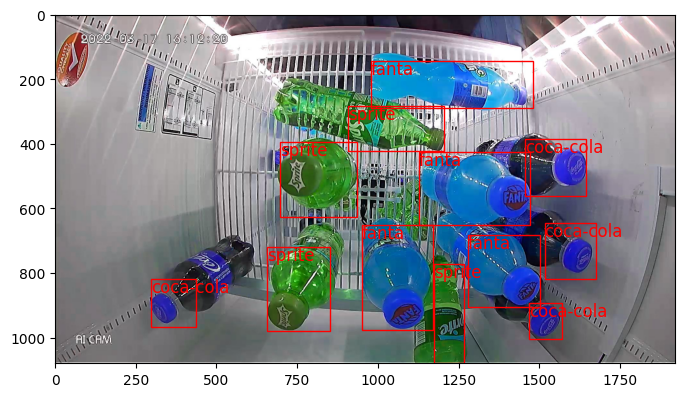

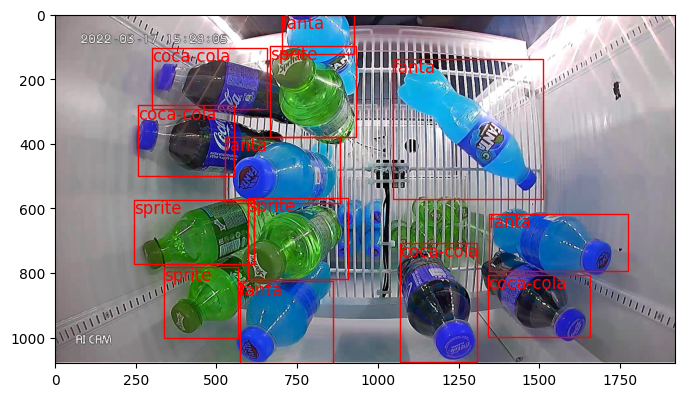

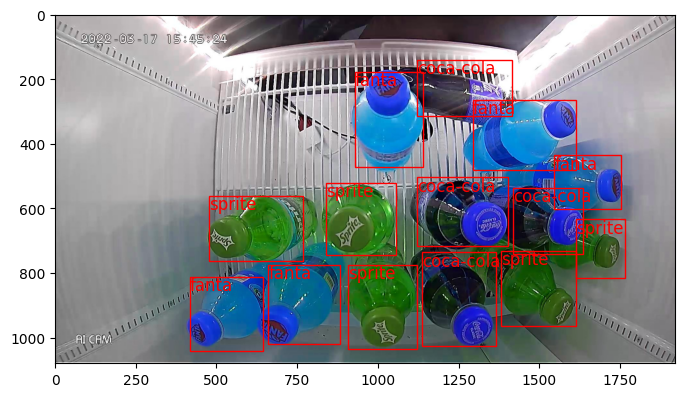

In [19]:
def display_img(dir, df,  n=3):

    img_names = os.listdir(dir)
    random.shuffle(img_names)
    img_names = img_names[:n]
    for name in img_names:
        img_path = os.path.join(f'{dir}/{name}')
        img = cv2.imread(img_path)

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img)

        rows = df[df['file_name'] == name]
        bboxes = []
        for _, row in rows.iterrows():
            bboxes.append((row.x, row.y, row.w, row.h, row.category_name)) # add category_name to bboxes
        for bbox in bboxes:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            # add category_name as text to the box
            ax.text(bbox[0], bbox[1] - 2, bbox[4], fontsize=12, color='r', verticalalignment='top')

    plt.show()


display_img(config.TEST_DIR, test_df)